In [3]:
#here is how we load a pre-trained model
import cv2
import tensorflow as tf

CATEGORIES = ["Dog", "Cat"]

def prepare(filepath):
    IMG_SIZE = 50
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

model = tf.keras.models.load_model("cat-dog-64x3-CNN.model")

In [4]:
#predict an image outside of your dataset
prediction = model.predict([prepare('dog.jpg')])
print(prediction)
print('To make the output more prety, do')
print(prediction[0][0])
print('To make the output more pretier, do')
print(int(prediction[0][0]))
print('Here is how we output the string insted of integer')
print(CATEGORIES[int(prediction[0][0])])

[[0.]]
To make the output more prety, do
0.0
To make the output more pretier, do
0
Here is how we output the string insted of integer
Dog


In [5]:
#predict an image outside of your dataset
prediction = model.predict([prepare('cat.jpeg')])
print(prediction)
print('To make the output more prety, do')
print(prediction[0][0])
print('To make the output more pretier, do')
print(int(prediction[0][0]))
print('Here is how we output the string insted of integer')
print(CATEGORIES[int(prediction[0][0])])

[[1.]]
To make the output more prety, do
1.0
To make the output more pretier, do
1
Here is how we output the string insted of integer
Cat


# This is an attempt to split the model

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 22, 22, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0

In [7]:
from tensorflow.keras import Input, Model
#partition1 holds the Conv layers
partition1 = Model(inputs=model.input, outputs=model.layers[6].output)
partition1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 50, 50, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 22, 22, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0     

In [8]:
# partition2 holds the dense(FC) layers
partition2_input = Input(model.layers[7].input_shape[1:])
partition2 = partition2_input
for layer in model.layers[7:]:
    partition2 = layer(partition2)
partition2 = Model(inputs=partition2_input, outputs=partition2)
partition2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7744)]            0         
_________________________________________________________________
dense (Dense)                (None, 64)                495680    
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 495,745
Trainable params: 495,745
Non-trainable params: 0
_________________________________________________________________


# Note:
**The if we sum the trainable parameters from partition1 and partition2, it will be equivalent to the total number of trainable parameters from the original model. Thus, our partition is correct.**

**Next, we will test the partitioned model on real images. If the output it yields is similar to the ones we got with the previous model, this is another sign of a correct partition.**

In [9]:
#take an input and feed it to the first partition of the model
prediction_partition1 = partition1.predict([prepare('cat.jpeg')])
print(prediction_partition1)

[[0.         0.         0.10544267 ... 0.         0.         0.        ]]


In [10]:
#take the output of the first partition of the model and feed it to the second partition of the model
prediction_partition2 = partition2.predict(prediction_partition1)
print(int(prediction_partition2))
if (prediction_partition2 == 1):
    print("This is a cat image")

1
This is a cat image


In [11]:
#take an input and feed it to the first partition of the model
prediction_partition1 = partition1.predict([prepare('dog.jpg')])
print(prediction_partition1)

[[0. 0. 0. ... 0. 0. 0.]]


In [12]:
#take the output of the first partition of the model and feed it to the second partition of the model
prediction_partition2 = partition2.predict(prediction_partition1)
print(int(prediction_partition2))
if (prediction_partition2 == 0):
    print("This is a dog image")

0
This is a dog image


In [13]:
#Array dimensions: this is 2D array
print(prediction_partition1.ndim)
print(prediction_partition1.shape)
print(prediction_partition1[0][1]) #print second element in the array

2
(1, 7744)
0.0


In [14]:
#this is the outout of max-pooling from first partition of the model
count_zeros = 0
count_non_zeros = 0
for i in range(len(prediction_partition1)):
    for j in range(len(prediction_partition1[i])):
        if (prediction_partition1[i][j] != 0):
            count_non_zeros += 1
            print("\t", prediction_partition1[i][j], end = '')
        else:
            count_zeros += 1

	 9.928892	 4.954602	 97.33441	 9.928892	 4.954602	 97.33441	 9.960758	 4.958248	 97.33441	 9.961778	 5.3882174	 97.32468	 2.5718453	 21.43826	 142.03474	 36.51242	 1.4348278	 0.68871915	 27.31936	 3.4671965	 3.0361004	 45.829376	 156.15088	 21.217035	 13.451865	 25.774195	 68.55817	 1.5339676	 100.795364	 16.288195	 10.061323	 4.9601226	 97.42621	 9.928892	 4.954602	 97.33441	 9.928892	 4.954602	 97.33441	 9.928892	 4.954602	 97.33441	 9.928892	 4.954602	 97.33441	 9.928892	 4.954602	 97.33441	 9.928892	 5.3189797	 97.68822	 9.354559	 25.31157	 117.61606	 3.0116615	 47.44862	 0.7440132	 45.91614	 41.78224	 154.37279	 44.151894	 74.71423	 53.191906	 76.56024	 147.9888	 71.26413	 36.830616	 55.666256	 63.024834	 73.6389	 11.787477	 23.704716	 25.544437	 32.892307	 103.07393	 46.253918	 9.928892	 4.954602	 97.33441	 9.928892	 4.954602	 97.33441	 9.928892	 4.954602	 97.33441	 9.928892	 4.954602	 97.33441	 9.928892	 4.9822216	 97.36245	 10.400463	 8.132596	 89.921135	 10.9246235	 17.312325

In [15]:
print(prediction_partition1[0][0])
print ("\nnon-zero count is:", count_non_zeros)
print ("\nzero count is:", count_zeros)

0.0

non-zero count is: 523

zero count is: 7221


# This is a dummy try:
In the following, I will try to add 1 to each of the non-zero max-pooling output. Then I will input them again inot the second partition of the model to see if the prediction cahnges.

The output shows a 0 which is correct.

In [16]:
for i in range(len(prediction_partition1)):
    for j in range(len(prediction_partition1[i])):
        if (prediction_partition1[i][j] != 0):
            prediction_partition1[i][j] += 1
            count_non_zeros += 1
            #print("\t", prediction_partition1[i][j], end = '')
        else:
            #prediction_partition1[i][j] += 255
            count_zeros += 1
#print(prediction_partition1[0][0])
prediction_partition2_after = partition2.predict(prediction_partition1)
if (prediction_partition2_after == 0):
    print("This is a dog: ", int(prediction_partition2_after))
else:
    print("This is a cat: ", int(prediction_partition2_after))

This is a dog:  0


In [17]:
# This is to see the image dimentionality
from PIL import Image
import numpy as np
img = Image.open('dog.jpg')
img_array = np.asarray(img)
print(img_array.shape)
print(img_array.ndim)

(215, 320, 3)
3


In [18]:
#conver 2D array to 3D array. This is trying to reconstruct the image from max-pooling output
new_array = np.asarray(prediction_partition1).reshape(88,88,1)
new_array[0][7][0] #the value was 9.928892

10.928892

In [19]:
#save the output of the first model as an image to see what's left
img = Image.fromarray(new_array, "RGB")
img.save('out1.png')

In [20]:
#try to reverse activation function to reconstruct the original image
#see what happens when you alter the output of the activation function (can you still reconstruct the image?)

In [21]:
#laplacian noise on cat image
import cv2
from matplotlib import pyplot as plt

img_o_c = cv2.imread('cat.jpeg')
img_l_c = cv2.Laplacian(img_o_c, cv2.CV_32F)
plt.figure()
plt.imshow(img_o_c)
plt.figure()
plt.imshow(img_l_c)
cv2.imwrite('out_laplace_c.jpg', img_l_c)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

In [22]:
#prediction after laplacian noise applied to the image
prediction_partition1 = partition1.predict([prepare('out_laplace_c.jpg')])
print(prediction_partition1)

[[0.5528326 0.        0.2315685 ... 0.        0.        0.       ]]


In [23]:
#take the output of the first partition of the model and feed it to the second partition of the model
prediction_partition2 = partition2.predict(prediction_partition1)
print(int(prediction_partition2))
if (prediction_partition2 == 1):
    print("This is a cat image")

0


# Important notes:
**The output image after the noise (out_laplace.jpg) can be seen as cat (*by human*). However, the prediciton is dog! Something is not right**

I added noise to the dog's image and the model was able to predect it correctlly. It alwyes predect dog! See the tree image and the output is dog!!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

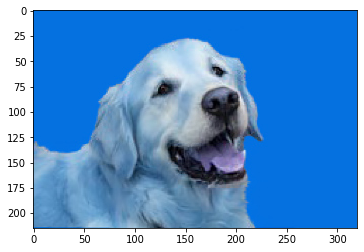

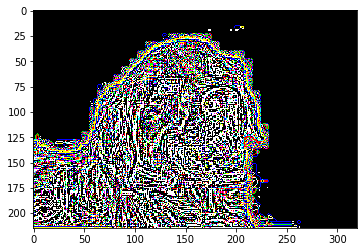

In [24]:
#laplacian noise on dog image
img_o_d = cv2.imread('dog.jpg')
img_l_d = cv2.Laplacian(img_o_d, cv2.CV_32F)
plt.figure()
plt.imshow(img_o_d)
plt.figure()
plt.imshow(img_l_d)
cv2.imwrite('out_laplace_d.jpg', img_l_d)

In [34]:
#prediction after laplacian noise applied to the image
prediction_partition1 = partition1.predict([prepare('out_laplace_d.jpg')])
print(prediction_partition1)

[[0.08016862 0.         0.         ... 0.         0.         0.        ]]


In [35]:
#take the output of the first partition of the model and feed it to the second partition of the model
prediction_partition2 = partition2.predict(prediction_partition1)
print(int(prediction_partition2))
if (prediction_partition2 == 0):
    print("This is a dog image")

0
This is a dog image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

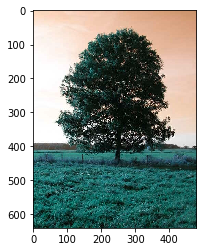

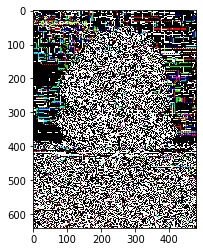

In [36]:
#laplacian noise on tree image
img_o_t = cv2.imread('tree.jpg')
img_l_t = cv2.Laplacian(img_o_t, cv2.CV_32F)
plt.figure()
plt.imshow(img_o_t)
plt.figure()
plt.imshow(img_l_t)
cv2.imwrite('out_laplace_t.jpg', img_l_t)

In [47]:
#prediction after laplacian noise applied to the image
prediction_partition1 = partition1.predict([prepare('out_laplace_t.jpg')])
print(prediction_partition1)

[[0. 0. 0. ... 0. 0. 0.]]


In [48]:
#take the output of the first partition of the model and feed it to the second partition of the model
prediction_partition2 = partition2.predict(prediction_partition1)
print(int(prediction_partition2))
if (prediction_partition2 == 0):
    print("This is a dog image")

0
This is a dog image


# This is a link for different image manipulation and nosing
https://scipy-lectures.org/advanced/image_processing/